In [389]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV, _CalibratedClassifier


# statistical reporting
import statsmodels.api as sm

# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots
from mcc_metastasis import data_cleaning

RANDOM = 0
figure_path = "../figures/NCDB_5_features/"

## 1. Prep data

- load data 

In [369]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")
## select relevant variables: removed sex and tumor site
df = df [['AGE', 'tumor_lymphocytes', 'lymph_vasc_invasion', 'tumor_site', 'metastasis']]

# clean up 
df['AGE'] = df.AGE.astype('float')
df['no_mets'] = df.metastasis.replace({0:1, 1:0})
df = df.drop(columns = 'metastasis')
df.no_mets.value_counts()

# apply one-hot encoding 
one_hot_tumor_site = pd.get_dummies(df.tumor_site, prefix = 'tumor_site', drop_first =True)
df = df.drop(columns = ['tumor_site'])
df = pd.concat([df, one_hot_tumor_site], axis = 1)
df.head()

,AGE,tumor_lymphocytes,lymph_vasc_invasion,no_mets,tumor_site_head_neck,tumor_site_other,tumor_site_trunk
0,90.0,NaN,NaN,NaN,0,0,1
1,71.0,NaN,0.0,1.0,1,0,0
2,87.0,NaN,NaN,0.0,0,0,0
3,43.0,0.0,NaN,1.0,0,1,0
4,81.0,NaN,NaN,NaN,0,1,0


### data version 1: drop all cases with missing data

In [370]:
df_complete = df.dropna(axis = 0)
df_complete.shape

(1956, 7)

### data version 2: retain samples using imputation


In [371]:
data_cleaning.get_missingness_table(df)

Missingness of features


,index,Missing
0,AGE,0
1,tumor_lymphocytes,12260
2,lymph_vasc_invasion,10026
3,no_mets,3572
4,tumor_site_head_neck,0
5,tumor_site_other,0
6,tumor_site_trunk,0


In [372]:
# what did i remove? sex, tumor site, 
df2 = df[(df.AGE.isnull() == False) & 
      #  (df.tumor_size.isnull() == False) &
         (df.no_mets.isnull() == False) &
        (df.tumor_lymphocytes.isnull() == False)]
     #   (df.immuno_suppressed.isnull() == False)]

# how many would we need to impute?
data_cleaning.get_missingness_table(df2)

Missingness of features


,index,Missing
0,AGE,0
1,tumor_lymphocytes,0
2,lymph_vasc_invasion,631
3,no_mets,0
4,tumor_site_head_neck,0
5,tumor_site_other,0
6,tumor_site_trunk,0


### Impute missing data 
- imputing lymph vasc invasion, tumor_size
- don't want to include outcome in imputation process...

In [373]:
outcome = df2['no_mets'].reset_index(drop = True)
features = df2.drop(columns =[ 'no_mets'])
imputer = KNNImputer()
imputed_features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
imputed_df = pd.concat([imputed_features, outcome], axis = 1)
imputed_df.shape

(2587, 7)

In [374]:
# checkL has non-binary values
imputed_features.lymph_vasc_invasion.head()

0    0.2
1    0.2
2    0.4
3    0.0
4    0.0
Name: lymph_vasc_invasion, dtype: float64

In [375]:
# binarize!! 
imputed_features['lymph_vasc_invasion'] = imputed_features.lymph_vasc_invasion.\
apply(lambda x : 1 if x > 0.5 else 0)



### Define preprocessing
- one-hot encode categorical features
-- tumor site: dropping one level as reference (extremity)
- standard scale (zscore) numeric, continuous features

In [376]:
# DEFINE PREPROCESSING 
num_features = ['AGE']
all_features = features.columns

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])

# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features)],
    remainder = 'passthrough')


# generate interaction terms from all features after transforming 
add_interactions = Pipeline(steps=[
    ('interaction_terms', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True))])

# put together the column transfrmer and option to add interactions
preproc_basic = Pipeline(steps = [('preproc', preprocessor)])
preproc_interactions = Pipeline(steps = [('preproc', preprocessor),
                                       ('int', add_interactions)])

preproc_X_check = pd.DataFrame(preproc_basic.fit_transform(imputed_features))    
preproc_X_check.shape

(2587, 6)

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 3 folds repeated 5x with random sampling

In [377]:
 # make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)
 

### Define Model: regularized logistic regression
- automated feature selection via L1 regularization  (Lasso)

### Tune the model 
- grid search with different levels of regularization (parameter C, inverse of alpha in R)
- smaller values of C = larger values of alpha = more regularization
- applied to cross-validation folds 
- get several metrics out! 


In [501]:
# set model to tune
Lasso =  LogisticRegression(class_weight = "balanced",
                                 penalty = 'l1',
                                 solver = 'liblinear', 
                                 max_iter = 1000, 
                               # C = 10,
                                 random_state = RANDOM)

# add extra step of calibration 
Isotonic = CalibratedClassifierCV(Lasso, method = "isotonic", cv = 3)

Sigmoid = CalibratedClassifierCV(Lasso, method = "sigmoid", cv = 3)

# define scores to get from each model 
def get_scores(y_test, y_pred):
        scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                          "accuracy", "f1 score", "pr_auc", "brier_score"],
                                "scores" : [precision_score(y_test, y_pred), 
                                           recall_score(y_test, y_pred),
                                            roc_auc_score(y_test, y_pred),
                                            accuracy_score(y_test, y_pred),
                                           f1_score(y_test, y_pred), 
                                           average_precision_score(y_test, y_pred), 
                                           brier_score_loss (y_test, y_pred)]
                               })
        return (scores)
# define hyper-parametrs to tune 
# C is the inverse of alpha 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}

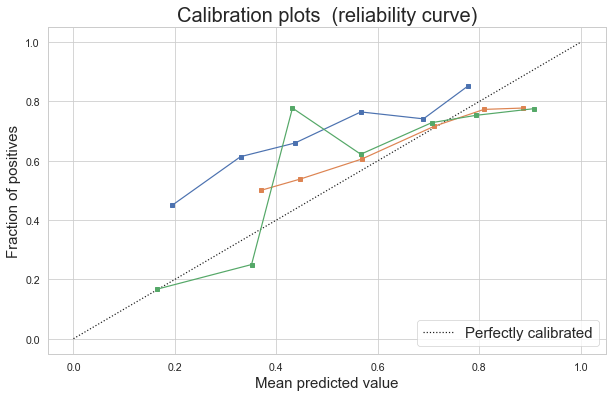

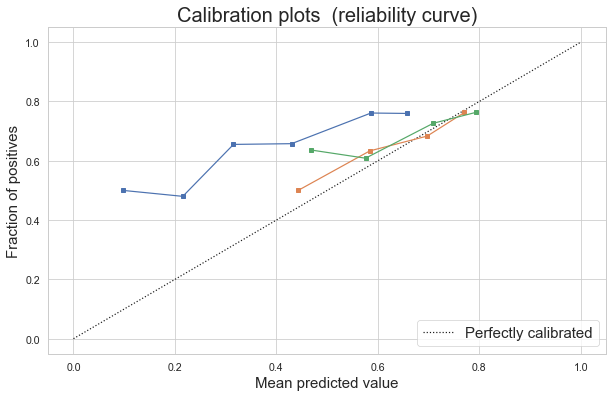

In [502]:
# define options for looop 
model_choices = [Lasso, Sigmoid, Isotonic]
model_names = ['Lasso', 'Sigmoid', 'Isotonic']

datasets = [df_complete, imputed_df]
dataset_names = ["complete", "imputed"]


grid_results = pd.DataFrame()
i = 0
for data in datasets:
    j  = 0 
    features = data.drop(columns = ['no_mets'])
    outcome = data['no_mets'].reset_index(drop = True)
    # split into train and test set 
    X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                              outcome,
                                                              stratify =outcome,
                                                              test_size = 0.33,
                                                              random_state = 0)
    # split further for extra validation set
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, 
                                                         y_trainval, 
                                                         test_size = 0.33,
                                                         stratify = y_trainval,
                                                         random_state = 0)
    # preproc by hand beccause pipeline doesn't wrk with calibrated classifier      
    X_train = preproc_choice.fit_transform(X_train)
    X_val = preproc_choice.fit_transform(X_val)
    X_test = preproc_choice.fit_transform(X_test)
    
    figure_path = "NCDB_5_features/"
    fig = plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    plt.xlabel("Mean predicted value", size = 15)
    plt.ylabel("Fraction of positives", size = 15)
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right", fontsize = 15)
    plt.title('Calibration plots  (reliability curve)', size = 20)
   # plt.savefig(os.path.join(figure_path, "calibration_plot.png"))
    
    for model in model_choices:

        model.fit(X_train, y_train)        
        y_val_probs = model.predict_proba(X_val)[:,1]
        y_val_pred = model.predict(X_val)

        scores = pd.DataFrame(get_scores(y_val, y_val_pred))
        scores['model'] = model_names[j]
        scores['dataset'] = model_names[i]
        grid_results = pd.concat([grid_results, scores], ignore_index = True)

        # PLOT 
        fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_val_probs, n_bins = 8)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = model_names[i])
        
        j = j+1
    i = i+1


### Visualize calibration effect on model scores 
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 

FileNotFoundError: [Errno 2] No such file or directory: 'NCDB_5_features/Calibration_validatiton_scores.png'

<Figure size 720x720 with 0 Axes>

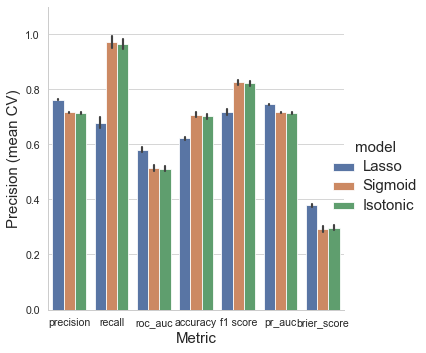

In [492]:
# figure of model comparisons on training  
plt.figure(figsize = (10, 10))
g = sns.catplot(data = grid_results,
                x = "metrics", y = 'scores', 
                 hue = "model",  
                kind = "bar") #  col = "metrics")
g.set_xlabels("Metric", size = 15)
g.set_ylabels("Precision (mean CV)", size = 15)
g.set(ylim= (0, 1.1))
plt.setp(g._legend.get_title(), fontsize = 15)
plt.setp(g._legend.get_texts(), fontsize = 15)
g.set_titles(size = 16)
plt.savefig(os.path.join(figure_path, "Calibration_validatiton_scores.png"))
